In [1]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

# Al Dhafra optimzation study

# inputs
-----

In [2]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
%%html
<style>.button1 {font-size:18px;}</style>

#### Battery legend choices

In [5]:
from ipywidgets import widgets, Layout, ButtonStyle
import json

desired_battery_range = []
battery_range = range(300, 2100 + 1, 300)
battery_options = {}
hbox_list = []
def checkbox_event_handler(**kwargs):
    desired_battery_range = []
    for i in battery_options:
        name = str(battery_options[i].description).split(" ")[0]
        value = battery_options[i].value
        if value is True:
            desired_battery_range.append(name)
    json.dump(desired_battery_range, open("desired_battery_range.json","w"))
        



for batt in battery_range:
    option = '{} kWh'.format(batt)
    battery_options[option] = widgets.Checkbox(
        value=False,
        description=option,
        disabled=False,
        indent=False
    )
    display(battery_options[option])
widgets.interactive_output(checkbox_event_handler,battery_options)


Checkbox(value=False, description='300 kWh', indent=False)

Checkbox(value=False, description='600 kWh', indent=False)

Checkbox(value=False, description='900 kWh', indent=False)

Checkbox(value=False, description='1200 kWh', indent=False)

Checkbox(value=False, description='1500 kWh', indent=False)

Checkbox(value=False, description='1800 kWh', indent=False)

Checkbox(value=False, description='2100 kWh', indent=False)

Output()

In [8]:
button = widgets.Button(description="Generate payback chart",
                        layout=Layout(width='300px', height='40px'),
                        button_style='warning',)
button.add_class('button1')
box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='center',
                width='100%')
box = widgets.HBox(children=[button],layout=box_layout)
display(box)

def on_button_clicked(b):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button.on_click(on_button_clicked)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


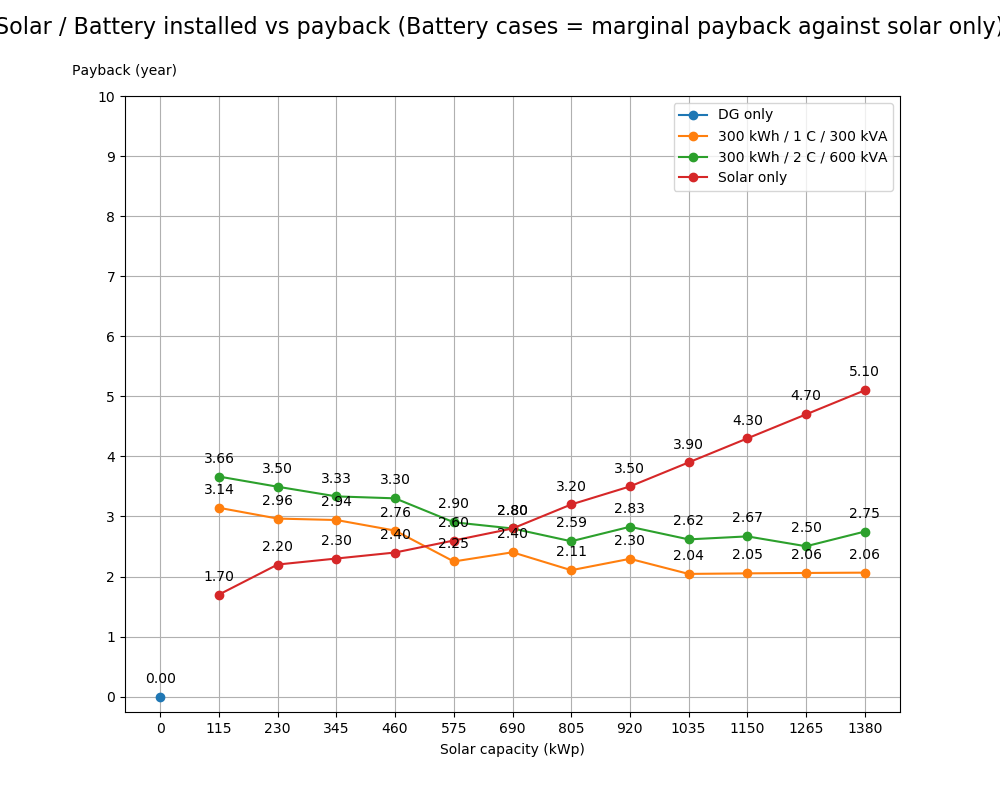

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [9]:
import pandas as pd
import numpy as np
import json
from itertools import combinations
import math
import calendar
import os
import matplotlib.pyplot as plt
%matplotlib notebook
marginal_payback = True
with open('desired_battery_range.json') as file:
    desired_battery_range = json.loads(file.read())
# key inverter, cost reduction on DG
DG_cost_reduction_per_month = {
    '600': 15000 / 3.672,
    '900': 15000 / 3.672,
    '300': 2850,
}

fig = plt.figure(figsize=(10, 8))
with open('opt_results5.json') as file:
    opt_cases = json.loads(file.read())

temp_opt_cases = {}
for item in opt_cases:
    if opt_cases[item]['solar'] > 0 and opt_cases[item]['battery'] == 0:
        temp_opt_cases[item] = opt_cases[item]

case_range = []
optimization_result = []
battery_legend = {}
solar_only_legend = []
battery_case_name = []
for key in opt_cases:
    solar = opt_cases[key]['solar']
    payback = opt_cases[key]['payback']
    case_range.append(solar)
    optimization_result.append(payback)
    battery = opt_cases[key]['battery']
    c_r = opt_cases[key]['c_r']
    inv = opt_cases[key]['inverter']
    investment = opt_cases[key]['investment']
    if (str(inv) in DG_cost_reduction_per_month) and payback > 0:
        margin = round(investment / payback, 0)
        adjusted_margin = margin + (DG_cost_reduction_per_month[str(inv)] * 12)
        payback = round(investment / adjusted_margin, 1)
    if marginal_payback is True:
        for item in temp_opt_cases:
            if temp_opt_cases[item]['solar'] == solar and temp_opt_cases[item]['battery'] == 0 and battery > 0:
                marginal_payback_value = (investment - temp_opt_cases[item]['investment']) / ((investment / payback) - (temp_opt_cases[item]['investment'] / temp_opt_cases[item]['payback']))
                payback = marginal_payback_value
            else:
                continue
    case_name = '{} kWh / {} C / {} kVA'.format(battery, c_r, inv)
    if battery > 0 and str(battery) in desired_battery_range:
        if case_name in battery_legend:
            pass
        else:
            battery_legend[str(case_name)] = []
        battery_legend[case_name].append([solar, payback, key])
    elif battery == 0 and solar > 0:
        solar_only_legend.append([solar, payback, key])
    elif solar == 0 and battery == 0:
        label = "{:.2f}".format(payback)
        plt.annotate(label,
            (solar, payback),
            textcoords="offset points",
            xytext=(0,10),
            ha='center')
        plt.plot(solar, payback, 'o-', label='DG only')
    else:
        pass

for group in battery_legend:
    x = []
    y = []
    for case in battery_legend[group]:
        x.append(case[0])
        y.append(case[1])
        label = "{:.2f}".format(case[1])
        plt.annotate(label,
            (case[0],case[1]),
            textcoords="offset points",
            xytext=(0,10),
            ha='center')
    plt.plot(x, y, 'o-', label=group)

solar_only_x_range = []
solar_only_y_range = []
for case in solar_only_legend:
    solar_only_x_range.append(case[0])
    solar_only_y_range.append(case[1])
    label = "{:.2f}".format(case[1])
    plt.annotate(label,
    (case[0],case[1]),
    textcoords="offset points",
    xytext=(0,10),
    ha='center')

plt.plot(solar_only_x_range, solar_only_y_range,'o-', label='Solar only')
plt.xticks(np.arange(min(case_range), max(case_range)+1, 115))
plt.yticks(np.arange(0, 10+1, 1))
plt.xlabel("Solar capacity (kWp)", fontdict=None, labelpad=5)
plt.ylabel("Payback (year)", fontdict=None, labelpad=5, rotation=0)
axPres  = fig.add_subplot(111)
axPres.yaxis.set_label_coords(0,1.03)
fig.suptitle('Solar / Battery installed vs payback (Battery cases = marginal payback against solar only)', fontsize=16)
plt.grid()
plt.legend(loc='best')
plt.show()